# Data Quality Issues

For this exerice, I will be focusing mainly on null values, duplicates, invalid data types and questionable anomalies. These issues will be discovered using both Pandas(Part 1) and SQL (Part 2)

## Part 1: Nulls and Duplicates (Pandas)

Below I am using Pandas to search through the different JSON files. I will ferequently use the pandas info() function to view the null count and data types. This helps to determine what data types to store the columns as in the SQL database.

In [1]:
import pandas as pd
import uuid

**Section 1**

First I like to use the head() function to get a feel of the data through a quick sample. This is generally what I do first when starting to access the data. 

Example is below:

In [2]:
brands = pd.read_json('/Users/brandonwagner/Desktop/brands.json',lines=True)
brands.head()

,_id,barcode,category,categoryCode,cpg,name,topBrand,brandCode
0,{'$oid': '601ac115be37ce2ead437551'},511111019862,Baking,BAKING,"{'$id': {'$oid': '601ac114be37ce2ead437550'}, ...",test brand @1612366101024,0.0,NaN
1,{'$oid': '601c5460be37ce2ead43755f'},511111519928,Beverages,BEVERAGES,"{'$id': {'$oid': '5332f5fbe4b03c9a25efd0ba'}, ...",Starbucks,0.0,STARBUCKS
2,{'$oid': '601ac142be37ce2ead43755d'},511111819905,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, ...",test brand @1612366146176,0.0,TEST BRANDCODE @1612366146176
3,{'$oid': '601ac142be37ce2ead43755a'},511111519874,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, ...",test brand @1612366146051,0.0,TEST BRANDCODE @1612366146051
4,{'$oid': '601ac142be37ce2ead43755e'},511111319917,Candy & Sweets,CANDY_AND_SWEETS,"{'$id': {'$oid': '5332fa12e4b03c9a25efd1e7'}, ...",test brand @1612366146827,0.0,TEST BRANDCODE @1612366146827


**Section 2**

As shown below brands have null values in category, categoryCode, topBrand and brandCode. Around 44.3% of category codes and 47.5% of top brand values are null.

The Brand ID and CPG ID are not all true UUIDs which lets me know that I need to store them as TEXT/VARCHAR.

The CPG ID has duplicates that we need to remove as well before storing in the CPG table.

In [3]:
#print(cpg.columns.tolist())
#print(brands_final.columns.tolist())
brands['_id'] = brands['_id'].apply(lambda x: x['$oid'])
cpg = pd.json_normalize(brands['cpg'])

brands_final = pd.concat([brands, cpg], axis=1)
brands_final = brands_final.drop('cpg', axis=1)
brands_final.info()
cpg.info()

def is_valid_uuid(value):
    try:
        uuid.UUID(value)
        return True
    except ValueError:
        return False
    
# Check if all values in the column are valid UUIDs
all_uuids = brands_final["_id"].apply(is_valid_uuid).all()
all_uuids_2 = cpg["$id.$oid"].apply(is_valid_uuid).all()
print()
print("Brand IDs are all UUIDs? " + str(all_uuids))
print("CPG IDs are UUIDs? " + str(all_uuids_2))

duplicates = cpg[cpg.duplicated(subset=["$id.$oid"])]
duplicates.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   _id           1167 non-null   object 
 1   barcode       1167 non-null   int64  
 2   category      1012 non-null   object 
 3   categoryCode  517 non-null    object 
 4   name          1167 non-null   object 
 5   topBrand      555 non-null    float64
 6   brandCode     933 non-null    object 
 7   $ref          1167 non-null   object 
 8   $id.$oid      1167 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 82.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   $ref      1167 non-null   object
 1   $id.$oid  1167 non-null   object
dtypes: object(2)
memory usage: 18.4+ KB

Brand IDs are all UUIDs? False
CPG IDs are UUIDs? False


,$ref,$id.$oid
3,Cogs,601ac142be37ce2ead437559
5,Cogs,601ac142be37ce2ead437559
6,Cogs,601ac142be37ce2ead437559
12,Cogs,559c2234e4b06aca36af13c6
14,Cogs,5332f5fbe4b03c9a25efd0ba


**Section 3**

The user.json was one of the cleaner data-sets though there are still nulls as seen below. 

- Duplicate IDs were noticed in the \_id field. In Python I handle these so we do not get a PRIMARY KEY exception when inserting into the database. In main.py, I compare against all columns when considering a full duplicate. If there were situations where there were. 
- I've also confirmed that columns such as \_id only have one data element in their JSON object as seen below.

In [4]:
users = pd.read_json('/Users/brandonwagner/Desktop/users.json',lines=True)
users.info()
duplicates = users[users.duplicated(subset=['_id'])]
duplicates.head()

df = pd.json_normalize(users['_id'])
all_keys = df.columns.tolist()
print()
print("Keys: " + " ".join(all_keys))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   _id           495 non-null    object
 1   active        495 non-null    bool  
 2   createdDate   495 non-null    object
 3   lastLogin     433 non-null    object
 4   role          495 non-null    object
 5   signUpSource  447 non-null    object
 6   state         439 non-null    object
dtypes: bool(1), object(6)
memory usage: 23.8+ KB

Keys: $oid


**Section 4**

Below I am looking at the receipts data to evaluate the null counts for each column. The amount of nulls in the purchaseDate, pointsEarned, and totalSpent are examples of missing values that I would need to notify the business of.

I also notice that
- The IDs aren't truly all UUIDs so I cannot store these in SQL as such
- There are user_ids in receipts that do not exists in the user JSON, so I will not be able to add a foreign key constraint (REFERENCE) until the missing users are added to the user table

In [5]:
receipts = pd.read_json('./files/receipts.json.gz', compression='gzip', lines=True)
#print(receipts.columns.tolist())

receipts.info()
#null_rows = receipts[receipts['rewardsReceiptItemList'].isnull()]


# Check if all values in the column are valid UUIDs
receipts['_id'] = receipts['_id'].apply(lambda x: x['$oid'])
all_uuids = receipts["_id"].apply(is_valid_uuid).all()
print()
print("All IDs are UUIDs? " + str(all_uuids))


#user_ids in receipts that don't exists in users
result = receipts[~receipts['_id'].isin(users['_id'])]
result.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   _id                      1119 non-null   object 
 1   bonusPointsEarned        544 non-null    float64
 2   bonusPointsEarnedReason  544 non-null    object 
 3   createDate               1119 non-null   object 
 4   dateScanned              1119 non-null   object 
 5   finishedDate             568 non-null    object 
 6   modifyDate               1119 non-null   object 
 7   pointsAwardedDate        537 non-null    object 
 8   pointsEarned             609 non-null    float64
 9   purchaseDate             671 non-null    object 
 10  purchasedItemCount       635 non-null    float64
 11  rewardsReceiptItemList   679 non-null    object 
 12  rewardsReceiptStatus     1119 non-null   object 
 13  totalSpent               684 non-null    float64
 14  userId                  

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
0,5ff1e1eb0a720f0523000575,500.0,"Receipt number 2 completed, bonus point schedu...",{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687536000},{'$date': 1609687531000},500.0,{'$date': 1609632000000},5.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,26.0,5ff1e1eacfcf6c399c274ae6
1,5ff1e1bb0a720f052300056b,150.0,"Receipt number 5 completed, bonus point schedu...",{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687488000},{'$date': 1609687483000},150.0,{'$date': 1609601083000},2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,11.0,5ff1e194b6a9d73a3a9f1052
2,5ff1e1f10a720f052300057a,5.0,All-receipts receipt bonus,{'$date': 1609687537000},{'$date': 1609687537000},NaN,{'$date': 1609687542000},NaN,5.0,{'$date': 1609632000000},1.0,"[{'needsFetchReview': False, 'partnerItemId': ...",REJECTED,10.0,5ff1e1f1cfcf6c399c274b0b
3,5ff1e1ee0a7214ada100056f,5.0,All-receipts receipt bonus,{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687539000},{'$date': 1609687534000},5.0,{'$date': 1609632000000},4.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,28.0,5ff1e1eacfcf6c399c274ae6
4,5ff1e1d20a7214ada1000561,5.0,All-receipts receipt bonus,{'$date': 1609687506000},{'$date': 1609687506000},{'$date': 1609687511000},{'$date': 1609687511000},{'$date': 1609687506000},5.0,{'$date': 1609601106000},2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,1.0,5ff1e194b6a9d73a3a9f1052


**Section 5**

Next we will check the receipt items column which is a list of JSON objects. We will transform this into normalized data by first "exploding" the list to get one entry per row, then "normalizing" the JSON objects to place each element into it's own column.

In [ ]:
receipts_item = receipts.explode('rewardsReceiptItemList')

receipts_item = pd.json_normalize(receipts_item['rewardsReceiptItemList'])
pd.set_option('display.max_columns', None)
receipts_item = pd.concat([receipts[['_id']], receipts_item], axis=1)
#print(receipts_item.columns.tolist())
receipts_item.info()
#null_rows = receipts_item[receipts_item['_id'].isnull()]
#null_rows.head()

**Section 6**

I noticed that there were two columns that looked and sounded like they may always contain the same value pointsPayerId and rewardsProductPartnerId. I confirm that this in the case below. For data like this, we have the option to only store it in one column in SQL as to not store unnecessary duplicate data.

I also will store this ID in a separate SQL table in case we are able to capture other information about the product partners.

In [7]:
df_compare = receipts_item[(receipts_item['pointsPayerId'] != receipts_item['rewardsProductPartnerId']) & receipts_item['pointsPayerId'].notna() & receipts_item['rewardsProductPartnerId'].notna()]

print(df_compare[['pointsPayerId', 'rewardsProductPartnerId']])
rpp = receipts_item[receipts_item['rewardsProductPartnerId'].notna()]
rpp = rpp[['rewardsProductPartnerId']]
rpp.info()

Empty DataFrame
Columns: [pointsPayerId, rewardsProductPartnerId]
Index: []
<class 'pandas.core.frame.DataFrame'>
Index: 2269 entries, 2 to 7205
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   rewardsProductPartnerId  2269 non-null   object
dtypes: object(1)
memory usage: 35.5+ KB


## Part 2: Statistical Analysis (SQL - Postgres)

**SQL to Find Points Earned (Receipts) Outliers**

We can find outlier values by finding the inter-quartile range in SQL. For an example, below I will use the point_earned column in the receipt database. I will include columns such as created date that may help figure out the culprit if it is truly invalid data.

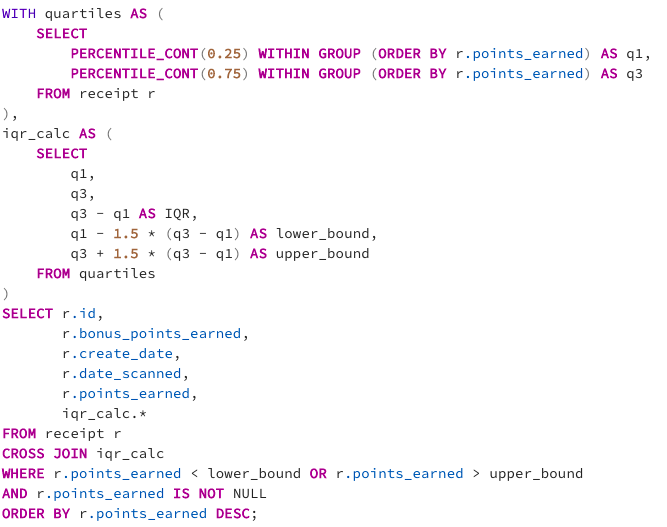

In [15]:
from IPython.display import Image
Image(filename="files/sql_outliers_receipt_points_earned.png", width=600, height=400)

**Results - 36 questionable rows**

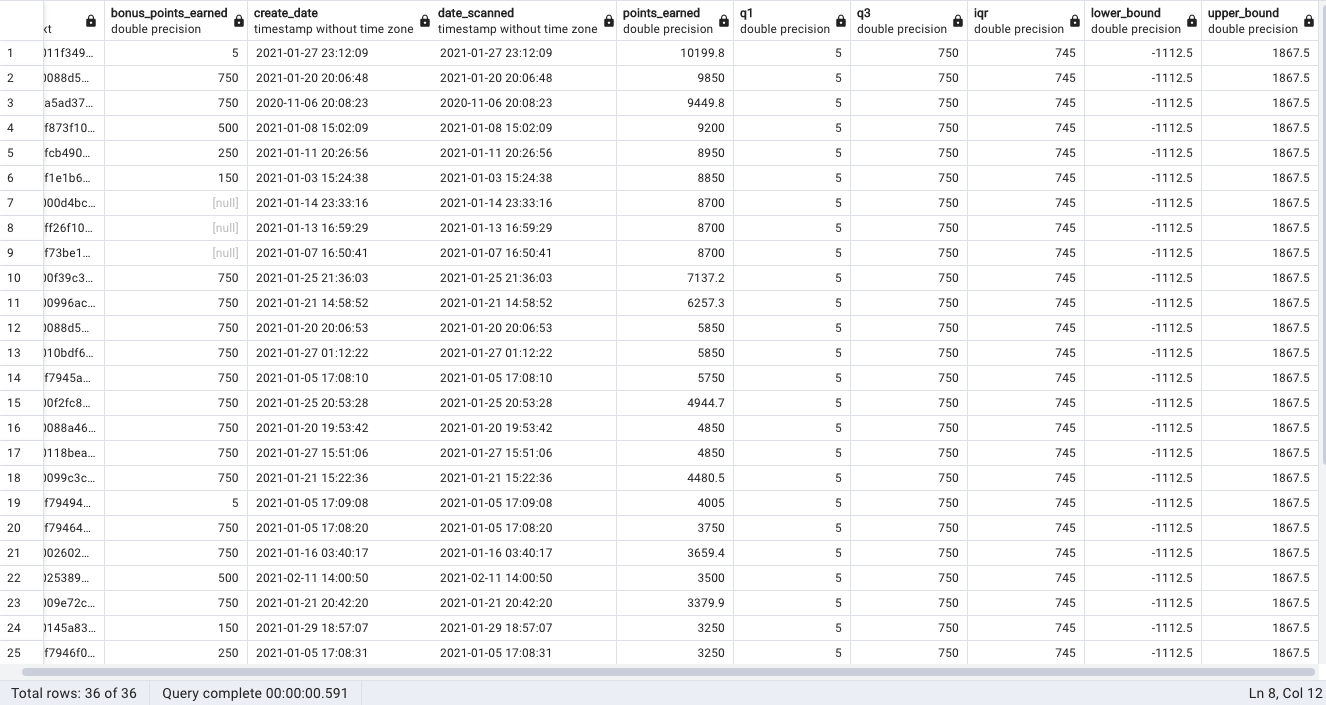

In [13]:
Image(filename="files/sql_outliers_receipt_points_earned_results.png", width=800, height=400)